## Pairs Trading - Oil & Gas Sector

In [18]:
import numpy as np
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
plt.style.use('fivethirtyeight')

In [19]:
end_date=dt.date.today()
start_date=end_date-pd.DateOffset(days=365)

symbols_list = ['PBF','PR','KOS','XOM','MRO','CVX','OXY','DK','SM','VTNR','WTI']
prices_df=yf.download(tickers=symbols_list, start=start_date, end=end_date) ['Adj Close']
prices_df=prices_df.dropna(axis=0)
prices_df

[*********************100%%**********************]  11 of 11 completed


Ticker,CVX,DK,KOS,MRO,OXY,PBF,PR,SM,VTNR,WTI,XOM
Date,,,,,,,,,,,
2023-03-14,154.365417,21.513922,6.87,22.831112,59.439262,40.622772,9.960309,28.146843,7.85,5.104985,103.245590
2023-03-15,147.682266,20.340084,6.21,20.894941,56.091549,38.369766,9.045195,25.190735,7.26,4.636364,98.109383
2023-03-16,148.152771,21.398458,6.37,21.632063,58.303612,39.711773,9.334178,26.398714,7.83,4.686217,97.539757
2023-03-17,146.280334,21.340733,6.20,20.835972,57.750591,39.594219,8.997030,24.866644,8.05,4.556598,96.390862
2023-03-20,148.431244,21.764084,6.39,21.366699,58.244358,41.259491,9.199320,25.868382,7.80,4.516716,98.910698
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,148.330002,25.280001,5.59,24.520000,60.869999,47.970001,15.483743,44.430000,1.40,2.620000,106.769997
2024-03-07,149.369995,26.030001,5.47,24.660000,61.049999,50.470001,15.761123,44.419998,1.33,2.610000,107.370003
2024-03-08,149.880005,26.500000,5.52,24.740000,60.799999,50.060001,15.810655,45.070000,1.29,2.580000,108.379997


In [20]:
def find_cointegrated_pairs(df,p_value_thresh):
    n = len(df.columns)
    pairs={}
    
    for i in range (n):
        for j in range (i+1, n):
            S1=df.iloc[:,i]
            S2=df.iloc[:,j]
            result= coint(S1, S2, trend='c', autolag='BIC')
            pvalue=round(result[1],2)
            if pvalue <= p_value_thresh:
                pairs[f"{df.columns[i]} - {df.columns[j]}"] = pvalue
    return pairs

pairs= find_cointegrated_pairs(df=prices_df,p_value_thresh=0.05)
pairs             

{'OXY - XOM': 0.05}

In [21]:
stock_1 = 'OXY'
stock_2='XOM'

coint(prices_df[stock_1],prices_df[stock_2], trend='c', autolag='BIC')

(-3.3345057097433117,
 0.05016342750267363,
 array([-3.94078403, -3.36067957, -3.06145832]))

In [22]:
selected_df=yf.download(tickers=[stock_1, stock_2], start='2019-03-13',end=dt.date.today()).stack()
selected_df['return'] = (selected_df['Adj Close']-selected_df['Open'])/selected_df['Open']
selected_df['forward return']= selected_df.groupby(level=1)['return'].transform(lambda x: x.shift(-1))
selected_df = selected_df[['Adj Close','forward return']].unstack().droplevel(axis=1, level=0)
selected_df.columns=['OXY','XOM','OXY_forward_return','XOM_forward_return']

selected_df[f'{stock_1}_return'] = np.log(selected_df[stock_1]).diff()
selected_df[f'{stock_2}_return'] = np.log(selected_df[stock_2]).diff()
selected_df=selected_df.dropna()
selected_df['hedge_ratio']=RollingOLS(selected_df[f'{stock_1}_return'],selected_df[f'{stock_2}_return'],window=180).fit().params.values
selected_df['spread']=(selected_df[stock_1]-selected_df[stock_2]*selected_df['hedge_ratio'])
selected_df

[*********************100%%**********************]  2 of 2 completed
/var/folders/vm/77fdm2ks1xz616jlwd2q7g0w0000gn/T/ipykernel_25451/3331953006.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  selected_df=yf.download(tickers=[stock_1, stock_2], start='2019-03-13',end=dt.date.today()).stack()


,OXY,XOM,OXY_forward_return,XOM_forward_return,OXY_return,XOM_return,hedge_ratio,spread
Date,,,,,,,,
2019-03-14,58.351089,62.398083,-0.096766,-0.224581,0.002303,-0.003351,NaN,NaN
2019-03-15,58.583752,62.173126,-0.088173,-0.218119,0.003979,-0.003612,NaN,NaN
2019-03-18,59.961773,62.894539,-0.120990,-0.231041,0.023250,0.011536,NaN,NaN
2019-03-19,59.210125,62.731636,-0.088513,-0.218815,-0.012615,-0.002593,NaN,NaN
2019-03-20,60.185478,63.080692,-0.101440,-0.214883,0.016339,0.005549,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-03-05,60.361839,105.639999,-0.007015,0.001407,-0.001649,0.012191,0.840990,-28.480297
2024-03-06,60.869999,106.769997,0.005600,0.007223,0.008383,0.010640,0.841114,-28.935690
2024-03-07,61.049999,107.370003,-0.001970,0.010725,0.002953,0.005604,0.843260,-29.490797


/var/folders/vm/77fdm2ks1xz616jlwd2q7g0w0000gn/T/ipykernel_25451/949261654.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f'{stock_1}-{round(selected_df.hedge_ratio[-1],2)}*{stock_2}')


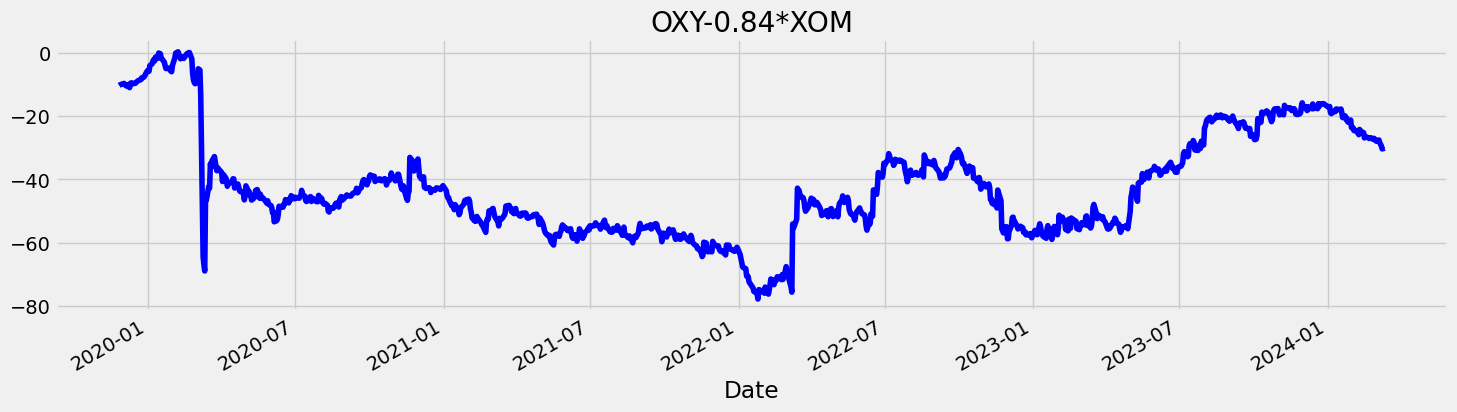

In [23]:
selected_df['spread'].plot(figsize=(16,4), color='blue')
plt.title(f'{stock_1}-{round(selected_df.hedge_ratio[-1],2)}*{stock_2}')
plt.show()

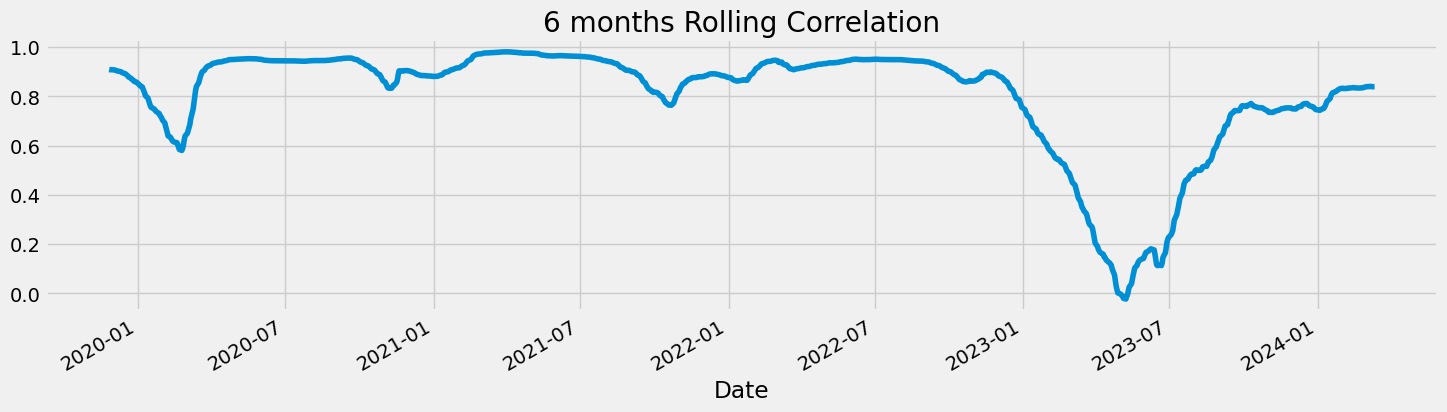

In [24]:
selected_df['roll_corr']= selected_df['OXY'].rolling(180).corr(selected_df['XOM'])
selected_df['roll_corr'].plot(figsize=(16,4))
plt.title('6 months Rolling Correlation')
plt.show()

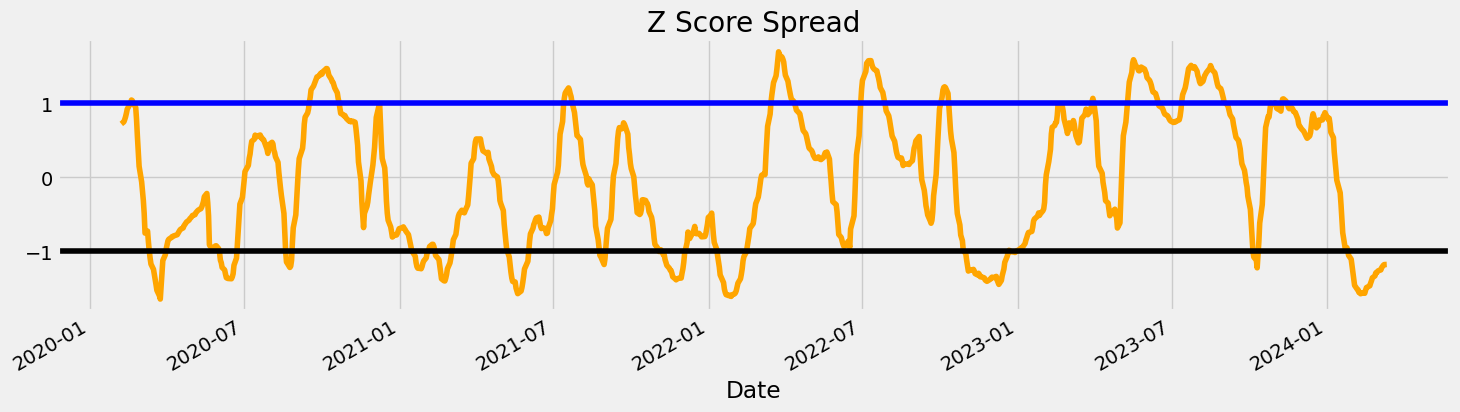

In [25]:
def smooth_zscore(spread):
    return(spread.rolling(12).mean()-spread.rolling(50).mean())/spread.rolling(50).std()

selected_df['z_score']=smooth_zscore(selected_df['spread'])
selected_df['z_score'].plot(figsize=(16,4), color='orange')
plt.title('Z Score Spread')
plt.axhline(1, color='blue')
plt.axhline(-1, color='k')
plt.show()

### Trade the Strategy

In [26]:
selected_df['signal']=selected_df.apply(lambda x: 1 if (x['z_score']<-1)
                                        else (-1 if (x['z_score']>1) else np.nan), axis=1)

selected_df['strategy_return']= selected_df[f'{stock_1}_forward_return']*selected_df['signal']+\
                                selected_df[f'{stock_2}_forward_return']*selected_df['signal']*-selected_df['hedge_ratio']
                                        
selected_df

,OXY,XOM,OXY_forward_return,XOM_forward_return,OXY_return,XOM_return,hedge_ratio,spread,roll_corr,z_score,signal,strategy_return
Date,,,,,,,,,,,,
2019-03-14,58.351089,62.398083,-0.096766,-0.224581,0.002303,-0.003351,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-15,58.583752,62.173126,-0.088173,-0.218119,0.003979,-0.003612,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-18,59.961773,62.894539,-0.120990,-0.231041,0.023250,0.011536,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-19,59.210125,62.731636,-0.088513,-0.218815,-0.012615,-0.002593,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-20,60.185478,63.080692,-0.101440,-0.214883,0.016339,0.005549,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05,60.361839,105.639999,-0.007015,0.001407,-0.001649,0.012191,0.840990,-28.480297,0.839993,-1.220196,1.0,-0.008198
2024-03-06,60.869999,106.769997,0.005600,0.007223,0.008383,0.010640,0.841114,-28.935690,0.840383,-1.202874,1.0,-0.000475
2024-03-07,61.049999,107.370003,-0.001970,0.010725,0.002953,0.005604,0.843260,-29.490797,0.839558,-1.187687,1.0,-0.011013


<AxesSubplot:xlabel='Date'>

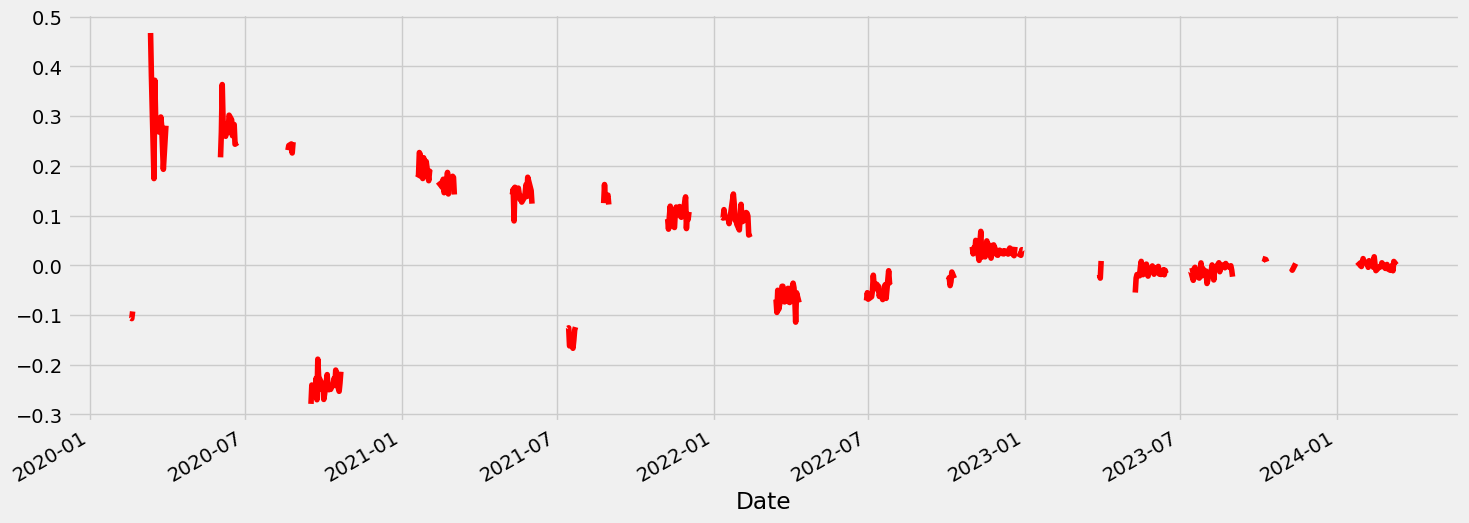

In [29]:
selected_df['strategy_return'].plot(figsize=(16,6), color='red')

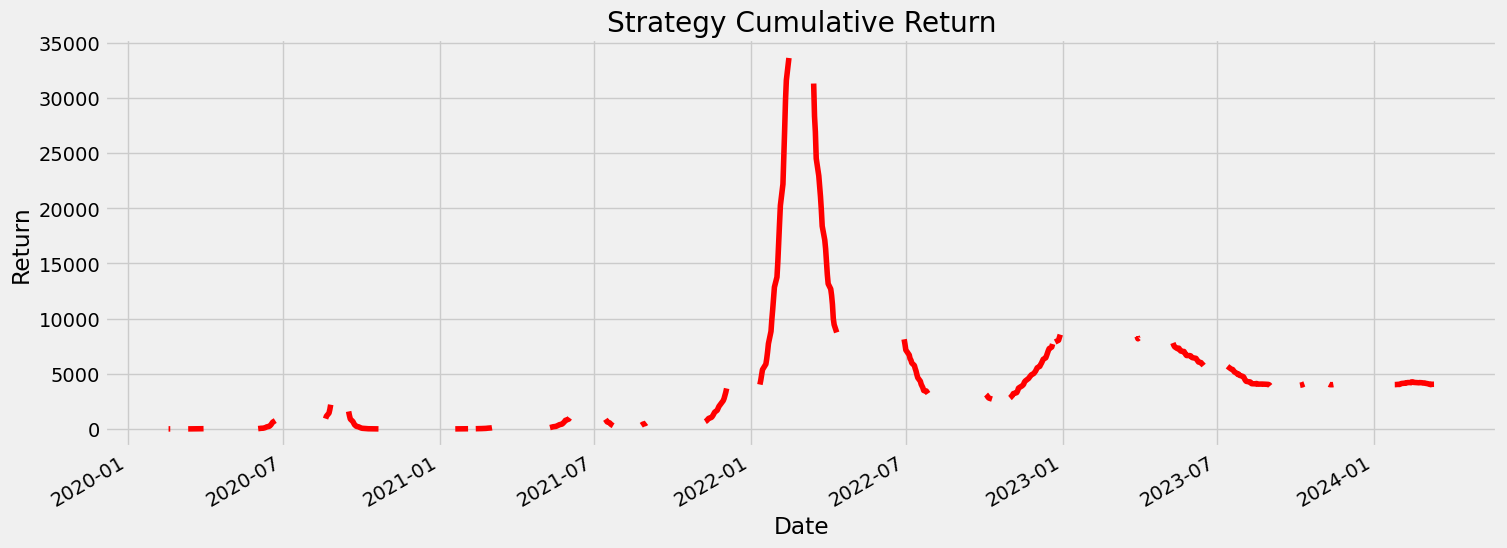

In [27]:
portfolio_return=np.exp(np.log1p(selected_df['strategy_return']).cumsum())
portfolio_return.plot(figsize=(16,6), color='red')
plt.title('Strategy Cumulative Return')
plt.ylabel('Return')
plt.show()

In [28]:
portfolio_return

Date
2019-03-14            NaN
2019-03-15            NaN
2019-03-18            NaN
2019-03-19            NaN
2019-03-20            NaN
                 ...     
2024-03-05    4059.217587
2024-03-06    4057.288559
2024-03-07    4012.604169
2024-03-08    4043.458347
2024-03-11    4047.440054
Name: strategy_return, Length: 1257, dtype: float64

In [ ]:
# Credit by Edoardo Alberto Donolato